# Phenome-Wide analysis on COPDgene data: R PIC-SURE API use-case

This notebook is an illustration example of how to use the R **PIC-SURE API** to select and query data from an HPDS-hosted database. It takes as use-case a simple PheWAS analysis. This notebook is intentionally straightforward, and explanation provided are only aimed at guiding through the PheWAS analysis pipeline. For a more step-by-step introduction to the R PIC-SURE API, see the `R_PICSURE-API_101_PheWAS_example.ipynb` Notebook.

**Before running this notebook, please be sure to get an user-specific security token. For more information on how to proceed, see the `get_your_token.ipynb` notebook**

## Environment set-up

### System requirements
- R 3.5 or later

### Packages installation

In [1]:
list_packages <- c("ggrepel",
                   "jsonlite",
                   "ggplot2",
                   "plyr",
                   "dplyr",
                   "tidyr",
                   "purrr",
                   "devtools")

for (package in list_packages){
     if(! package %in% installed.packages()){
         install.packages(package, dependencies = TRUE)
     }
     library(package, character.only = TRUE)
}

Loading required package: ggplot2


Attaching package: ‘dplyr’


The following objects are masked from ‘package:plyr’:

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘purrr’


The following object is masked from ‘package:plyr’:

    compact


The following object is masked from ‘package:jsonlite’:

    flatten


Loading required package: usethis



#### Installing latest R PIC-SURE API libraries from github

In [2]:
devtools::install_github("hms-dbmi/pic-sure-r-client")
devtools::install_github("hms-dbmi/pic-sure-r-adapter-hpds")

Skipping install of 'picsure' from a github remote, the SHA1 (d62fec5d) has not changed since last install.
  Use `force = TRUE` to force installation

Skipping install of 'hpds' from a github remote, the SHA1 (353b5419) has not changed since last install.
  Use `force = TRUE` to force installation



#### Loading user-defined functions

In [3]:
source("R_lib/utils.R")

## Connecting to a PIC-SURE network

In [4]:
PICSURE_network_URL <- "https://biodatacatalyst.integration.hms.harvard.edu/picsure"
resource_id <- "02e23f52-f354-4e8b-992c-d37c8b9ba140"
token_file <- "token.txt"

In [5]:
token <- scan(token_file, what = "character")

In [6]:
myconnection <- picsure::connect(url = PICSURE_network_URL,
                                 token = token)

In [7]:
resource <- hpds::get.resource(myconnection,
                               resourceUUID = resource_id)

## PheWAS analysis

In a nutshell, this PheWAS analysis follows those subsequent steps:
- Retrieving the variables dictionary, using the PIC-SURE API dedicated methods
- From the info provided by the dictionary, retrieving the data in an exploitable format through PIC-SURE API calls
- Data management
- Running univariate tests again every phenotypes variable
- Adjusting for multiple testing issue
- Plotting the results


This analysis is conducted using COPDGene Study data. The study overall goal is to detect underlying genetic factors to develop Chronic Obstructive Pulmonary Disease (COPD), and enrolled more than 10,000 individuals ([more information on COPDGene Study](http://www.copdgene.org)).

### 1. Retrieving variable dictionary from HPDS Database

In [8]:
copdgene_variables <- hpds::find.in.dictionary(resource, "Genetic Epidemiology of COPD (COPDGene)")
consent_variable <- hpds::find.in.dictionary(resource, "Study Accession with Consent Code")

In [9]:
copdgene_dic <- hpds::extract.dataframe(copdgene_variables)
consent_dic <- hpds::extract.dataframe(consent_variable)
plain_variablesDict <- dplyr::bind_rows(copdgene_dic, consent_dic) %>% dplyr::arrange(name)

In [10]:
# Display the variables tree hierarchy from the variables name
variablesDict <- get_multiIndex_variablesDict(plain_variablesDict)
head(variablesDict)

level_0                                 level_1
1 Genetic Epidemiology of COPD (COPDGene) Samples
2 Genetic Epidemiology of COPD (COPDGene) Samples
3 Genetic Epidemiology of COPD (COPDGene) Samples
4 Genetic Epidemiology of COPD (COPDGene) Samples
5 Genetic Epidemiology of COPD (COPDGene) Samples
6 Genetic Epidemiology of COPD (COPDGene) Samples
  level_2                                   level_3 level_4 level_5
1 Sample ID used in the Source Repository   NA      NA      NA     
2 Sample ID                                 NA      NA      NA     
3 Sample Use                                NA      NA      NA     
4 Source repository where samples originate NA      NA      NA     
5 Study                                     NA      NA      NA     
6 Subject ID                                NA      NA      NA     
  simplified_name                          
1 Sample ID used in the Source Repository  
2 Sample ID                                
3 Sample Use                               
4 Source repository where samples originate
5 Study                                    
6 Subject ID                               
  name                                                                                           
1 \\Genetic Epidemiology of COPD (COPDGene)\\Samples\\Sample ID used in the Source Repository\\  
2 \\Genetic Epidemiology of COPD (COPDGene)\\Samples\\Sample ID\\                                
3 \\Genetic Epidemiology of COPD (COPDGene)\\Samples\\Sample Use\\                               
4 \\Genetic Epidemiology of COPD (COPDGene)\\Samples\\Source repository where samples originate\\
5 \\Genetic Epidemiology of COPD (COPDGene)\\Samples\\Study\\                                    
6 \\Genetic Epidemiology of COPD (COPDGene)\\Samples\\Subject ID\\                               
  observationCount categorical
1    12             TRUE      
2   415            FALSE      
3 10003             TRUE      
4    12             TRUE      
5 10003             TRUE      
6 10003             TRUE      
  categoryValues                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             

### 2. Selecting variables and retrieving data from HPDS

Subseting to keep only the phenotypical variables + the "affection status", that will be used as the dependent variable for this illustration use-case.

In [11]:
mask_copdgene <- variablesDict["level_0"] == 'Genetic Epidemiology of COPD (COPDGene)'
mask_pheno <- variablesDict["level_1"] == 'Subject Phenotype'
mask_status <- variablesDict["level_2"] == 'Affection status'
mask_to_drop <- variablesDict[["simplified_name"]] %in% list("Dbgap_id", "De-identified site code", "A1AD: phenotype/genotype")
mask_vars <- mask_copdgene & (mask_pheno | mask_status) & !mask_to_drop
selected_vars <- variablesDict[mask_vars, ]$name %>% unname() %>% as.list()

In [12]:
print(selected_vars[1:5])

[[1]]
[1] "\\Genetic Epidemiology of COPD (COPDGene)\\Subject Phenotype\\6MinWalk\\Distance walked [ft]\\"

[[2]]
[1] "\\Genetic Epidemiology of COPD (COPDGene)\\Subject Phenotype\\6MinWalk\\Six minute walk: course layout\\"

[[3]]
[1] "\\Genetic Epidemiology of COPD (COPDGene)\\Subject Phenotype\\6MinWalk\\Six minute walk: was your walking limited?\\"

[[4]]
[1] "\\Genetic Epidemiology of COPD (COPDGene)\\Subject Phenotype\\6MinWalk\\Supplemental O2 used during 6-min walk L/min\\"

[[5]]
[1] "\\Genetic Epidemiology of COPD (COPDGene)\\Subject Phenotype\\6MinWalk\\Walk symptoms: back pain\\"



Here we use the accession number of COPDGene study to select only the records that do match this strings.

In [13]:
phs_values = strsplit(consent_dic[["categoryValues"]], ",") %>% unlist()
phs_copdgene = grep("phs000179\\.*", phs_values, perl=T, value=T) %>% as.list()
# phs_copdgene = do.call(list, list(phs_copdgene))

Retrieving the data:

In [14]:
my_query = hpds::new.query(resource = resource)

In [15]:
hpds::query.filter.add(query = my_query,
                      keys = consent_dic[["name"]],
                      phs_copdgene)

In [16]:
hpds::query.select.add(query = my_query,
                      keys = selected_vars)
facts = hpds::query.run(query = my_query, result.type = "dataframe")

In [17]:
cat(paste0(dim(facts)[1], " rows, ", dim(facts)[2], " columns"))

10385 rows, 328 columns

In [18]:
tail(facts)

Patient.ID
10380  45783    
10381  45784    
10382  45785    
10383  45786    
10384 122723    
10385 507518    
      X.Genetic.Epidemiology.of.COPD..COPDGene..Subject.Phenotype.6MinWalk.Distance.walked..ft..
10380 1466                                                                                      
10381  865                                                                                      
10382 1482                                                                                      
10383  NaN                                                                                      
10384  NaN                                                                                      
10385  NaN                                                                                      
      X.Genetic.Epidemiology.of.COPD..COPDGene..Subject.Phenotype.6MinWalk.Six.minute.walk..course.layout.
10380 Straight                                                                                            
10381 Straight                                                                                            
10382 Circular                                                                                            
10383 Straight                                                                                            
10384                                                                                                     
10385                                                                                                     
      X.Genetic.Epidemiology.of.COPD..COPDGene..Subject.Phenotype.6MinWalk.Six.minute.walk..was.your.walking.limited..
10380 No                                                                                                              
10381 Yes                                                                                                             
10382 No                                                                                                              
10383 No                                                                                                              
10384                                                                                                                 
10385                                                                                                                 
      X.Genetic.Epidemiology.of.COPD..COPDGene..Subject.Phenotype.6MinWalk.Supplemental.O2.used.during.6.min.walk.L.min.
10380   0                                                                                                               
10381   4                                                                                                               
10382   0                                                                                                               
10383   6                                                                                                               
10384 NaN                                                                                                               
10385 NaN                                                                                                               
      X.Genetic.Epidemiology.of.COPD..COPDGene..Subject.Phenotype.6MinWalk.Walk.symptoms..back.pain.
10380                                                                                               
10381 Checked (multiple-response)                                                                   
10382                                                                                               
10383                                                                                               
10384                                                                                               
10385                                                                                               
      X.Genetic.Epidemiology.of.COPD..COPDGene..Subject.Phenotype.6MinWa

### 3. Data-management

Since variable names are not the same between the dictionary and the dataframe columns, a temporary workaround is needed: parsing variables names from variables dictionary to match actual column names. (issue arise from the fact the R data.frame column names cannot contain spaces).

In [19]:
variablesDict[["df_name"]] <- parsing_varNames(variablesDict[["name"]])
variablesDict[["df_name"]] <- variablesDict[["df_name"]]

In [20]:
checking_parsing(names(facts)[-1], variablesDict[mask_vars, ][["df_name"]])

X._Consents.Short.Study.Accession.with.Consent.Code.
not found in parsed varnames



not found in original varnames




#### Selecting variables regarding their types

One important step in a PheWAS is to get the distinction between categorical and numerical variables. This distinction is straightforward using the variables dictionary.

In [21]:
mask_categories <- variablesDict[, "categorical"] == TRUE
categorical_varnames <- variablesDict[mask_categories & mask_vars, ][["df_name"]]
continuous_varnames <- variablesDict[!mask_categories & mask_vars, ][["df_name"]]

### Selecting the dependent variable to study
Most of PheWAS use a genetic variant as the variable used to separate the population between cases and controls. However the population doesn't have to be dichotomized using a genetic variant, and any phenotypic variable could be used to run a PheWAS analysis (see for example [*Neuraz et al.*, 2013](https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1003405)).

Here we will use the **COPD status** as the case-control variable to dichotomize the population in our analysis (ie the dependent variable for which univariate association test will be run against).

In [22]:
dependent_varname <- variablesDict[variablesDict[["simplified_name"]] == "Affection status",][["df_name"]]

In [23]:
categorical_varnames <- categorical_varnames[-which(categorical_varnames == dependent_varname)]

In [24]:
table(facts[[dependent_varname]])


                                     Case              Control 
                  14                 3692                 4499 
Exclusionary Disease                Other 
                  64                 2116 

Then we subset our population regarding the relevant values for the COPD diagnosis variable (i.e. keeping "Case" and "Control" individuals, and discarding "Other", "Control, Exclusionary Disease", and null values).

In [25]:
mask_dependent_varname = facts[[dependent_varname]] %in% c("Case", "Control")

In [26]:
facts <- facts[mask_dependent_varname,]

In [27]:
count_case_control <- table(facts[[dependent_varname]])

In [28]:
sprintf("Control: %i individuals\nCase: %i individuals",
        count_case_control["Control"],
        count_case_control["Case"]) %>% cat()

Control: 4499 individuals
Case: 3692 individuals

### 4. Univariate statistical tests

Univariate logistic regression models will be runned using each phenotypical variable as the regressor, and Likelihood Ratio Test p-values for the model will be used to assess the significance of the association

In [29]:
## Unified univariate tests
### Likelihood ratio test of a logistic model including the independent variable over model without this variable
anova_model <- function(data, dependent_var, independent_var) {
    model <- glm(as.formula(paste(dependent_var, "~ 1 +", independent_var)),
                 data = data,
                 family = binomial(link="logit"))
    model_reduced <- glm(as.formula(paste(dependent_var, "~ 1")),
                         data = data,
                         family = binomial(link="logit"))
    p_val <- anova(model, model_reduced, test =  "LRT")[2, "Pr(>Chi)"]
    return(p_val)    
}

In [30]:
independent_varnames = c(categorical_varnames, continuous_varnames)

In [31]:
pvalues_list = list()
error_list =  list()
warning_list = list()
cat("length categorical", length(categorical_varnames), "\n")
cat("length independent", length(independent_varnames), "\n")

length categorical 181 
length independent 325 


In [32]:
for (independent_varname in independent_varnames) {
    dataset <- na.omit(facts[, c(dependent_varname, independent_varname)])
    tryCatch({
                pvalues_list[[independent_varname]] <- anova_model(dataset, dependent_varname, independent_varname)
#                error_list[[independent_varname]] <- NA
 #               warning_list[[independent_varname]] <- NA
    },
             error = function(e) {
                print(paste("error", independent_varname))
                pvalues_list[[independent_varname]] <- NA
                error_list[[independent_varname]] <- e
                warning_list[[independent_varname]] <- NA
             },
             warning = function(w) {
                print(paste("warning", independent_varname))
                pvalues_list[[independent_varname]] <- NA
                error_list[[independent_varname]] <- NA
                warning_list[[independent_varname]] <- w                 
             }
        )
}

[1] "error X.Genetic.Epidemiology.of.COPD..COPDGene..Subject.Phenotype.Respiratory.Disease.COPD.Exacerbations.in.the.Last.Year.Lung.Problems.Other.primary.disease.so.subject.excluded.from.COPD.disease.analysis..ILD..Bronchiectasis.."
[1] "warning X.Genetic.Epidemiology.of.COPD..COPDGene..Subject.Phenotype.CT.Acquisition.Parameters.CT.Slicer.HU.15th.percentile.Exp.Total.lung.CT.Slicer."
[1] "warning X.Genetic.Epidemiology.of.COPD..COPDGene..Subject.Phenotype.Spirometry.Postbronchodilator.Pulmonary.Function.Testing.FEF.FEF.25.75.post.bronch."
[1] "warning X.Genetic.Epidemiology.of.COPD..COPDGene..Subject.Phenotype.Spirometry.Postbronchodilator.Pulmonary.Function.Testing.FEV.FEV1...pred.post.bronch."
[1] "warning X.Genetic.Epidemiology.of.COPD..COPDGene..Subject.Phenotype.Spirometry.Postbronchodilator.Pulmonary.Function.Testing.FEV.FEV1.FVC.post.bronch."
[1] "warning X.Genetic.Epidemiology.of.COPD..COPDGene..Subject.Phenotype.Spirometry.Prebronchodilator.Pulmonary.Function.Testing.FEF.25.

In [33]:
df_pvalues <- data.frame(
    "df_name" = names(pvalues_list),
    "pvalues" = simplify(unname(pvalues_list)),
    stringsAsFactors = F
)

In [34]:
df_pvalues[["log_pvalues"]] <- -log10(df_pvalues$pvalues)

In [35]:
variablesDict_enhanced <- dplyr::left_join(variablesDict, df_pvalues, by="df_name")
variablesDict_enhanced <- dplyr::left_join(variablesDict, df_pvalues, by="df_name")

#### Univariate test p-values distribution

Warning message:
“Removed 24 rows containing non-finite values (stat_bin).”


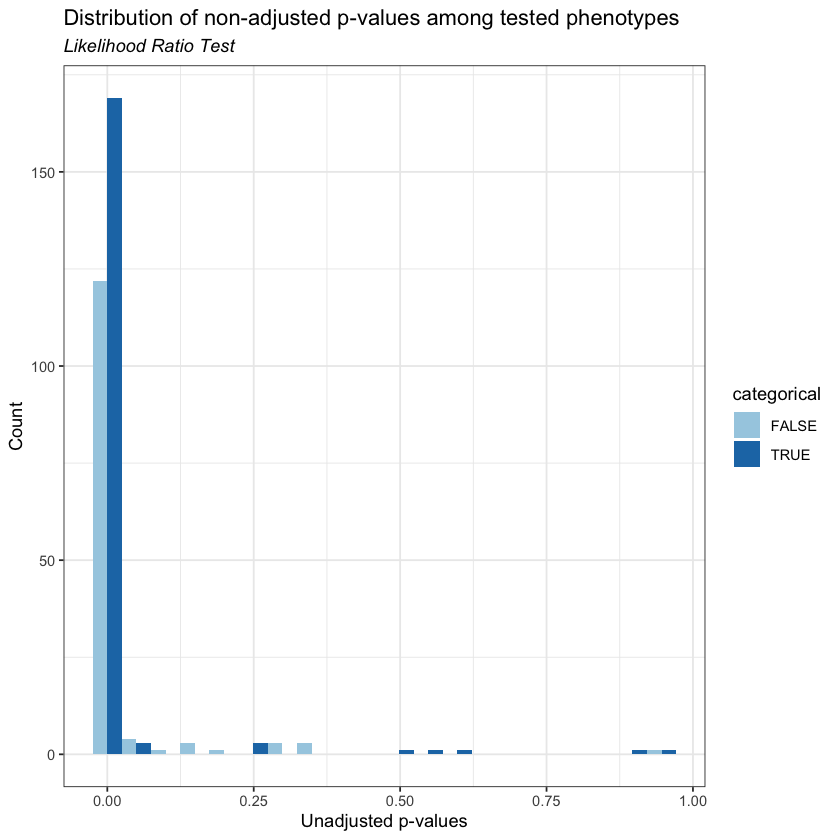

In [36]:
ggplot(aes_string(x = "pvalues",
                 fill = "categorical"),
       data = variablesDict_enhanced) +
geom_histogram(bins=20, position = "dodge") +
scale_fill_brewer(palette='Paired') +
labs(title = "Distribution of non-adjusted p-values among tested phenotypes ",
    subtitle = expression(italic("Likelihood Ratio Test"))) +
xlab("Unadjusted p-values") +
ylab("Count") +
theme_bw()

## 5. Multiple hypotheses testing correction: Bonferroni Method

In order to handle the multiple comparison issue (increase in the probability to "discover" false statistical associations, because of the number of tests performed), we will use the Bonferroni correction method. Although many other multiple comparison exist, Bonferroni is the most straightforward to use, because it doesn't require assumptions about variables correlation. Other PheWAS analysis also use False Discovery Rate controlling procedures ([see reference](https://en.wikipedia.org/wiki/False_discovery_rate)).

In a nutshell, Bonferonni allows to calculate a corrected "statistical significant threshold" according to the number of test performed. Every p-value below this threshold will be deemed statistically significant.

In [37]:
variablesDict_enhanced$adj_pvalues <- p.adjust(variablesDict_enhanced$pvalues, method="bonferroni")

In [38]:
variablesDict_enhanced$log_adj_pvalues <- -log10(variablesDict_enhanced$adj_pvalues)

## 6. Result visualisations: Manhattan plot

Manhattan plot is the classical results representation of a PheWAS analysis. It plots every each tested phenotypical variables on the X-axis, against its *-log(pvalue)* on the Y-axis. The horizontal line represent the adjusted significance level threshold.

#### Preparing data

In [39]:
corrected_alpha <- 0.05/length(variablesDict_enhanced$pvalues) # Using Bonferonni method
adj_corrected_alpha <- -log10(corrected_alpha)

In [40]:
non_nan <- which(!is.na(variablesDict_enhanced$pvalues))
plot_df <- variablesDict_enhanced[non_nan, ]
plot_df$log_pvalues <- round(plot_df$log_pvalues, 5)

plot_df = variablesDict[, c("df_name", "level_2")] %>%
plyr::rename(replace = c("level_2" = "category")) %>%
right_join(plot_df, by="df_name")

plot_df$df_name <- as.factor(plot_df$df_name)
plot_df <- plot_df[order(plot_df$category),]
plot_df$category <- factor(plot_df$category)
plot_df$name <- factor(plot_df$name, levels=plot_df$name[order(plot_df$category)])

In [41]:
# Suppressing Inf log(p-values)
plot_df <- plot_df[plot_df$log_pvalues != Inf,]

In [42]:
# Selecting 4 largest p-values, to be annotated in the Manatthan plot

largest_pvalues_indices <- order(plot_df[["log_pvalues"]], decreasing=T)[1:4]
plot_df$to_annotate <- "no"
plot_df[largest_pvalues_indices, "to_annotate"] <- "yes"

#### Plotting the data

In [43]:
options(repr.plot.width=12, repr.plot.height=8)

In [44]:
my_theme <- theme_bw() +
theme(axis.title.y = element_text(face="italic", size=15),
      title = element_text(size=20),
      axis.title.x = element_text(size=15),
      axis.text.x = element_text(angle=35, hjust=1),
      legend.position = "none",
      panel.grid.major.x = element_blank()
      )


In [45]:
paired_colors <- c("navyblue", "lightskyblue")
#paired_colors <- c("green", "red")

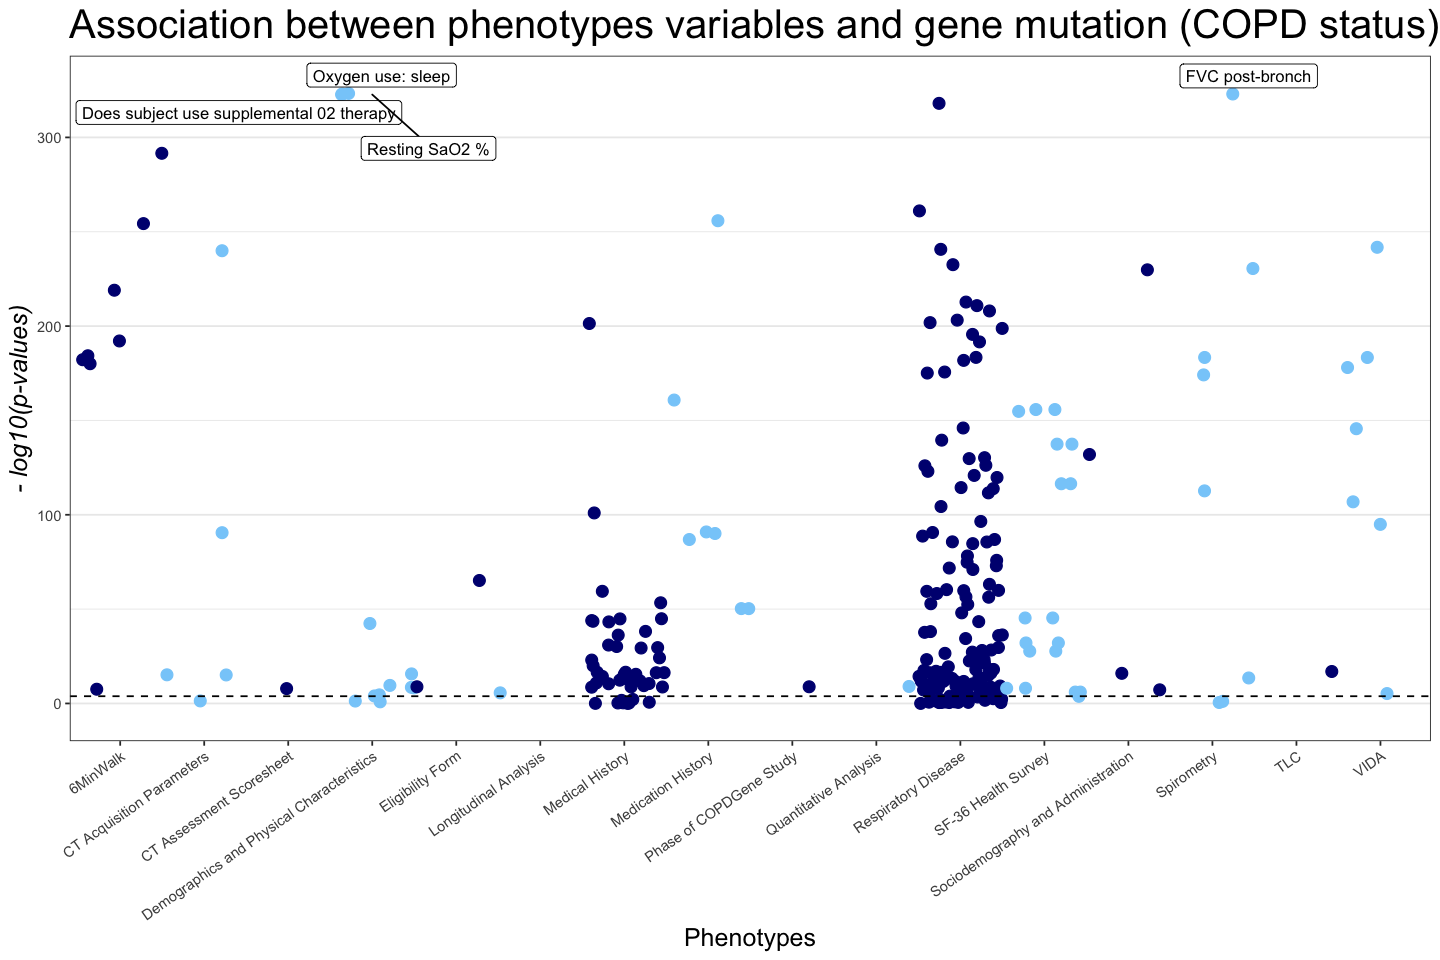

In [46]:
# Manatthan plot using geom_jitter --> more suitable when number of point per category is enough
ggplot(plot_df, aes(x=category, y=log_pvalues)) +
geom_jitter(alpha=1, aes_string(colour="category"),
           width=0.5,
           size=3) +
geom_hline(yintercept=adj_corrected_alpha, linetype="dashed") +
scale_y_continuous(expand = c(0, 20) ) +
scale_color_manual(values = rep(paired_colors, times=20)) +
geom_label_repel( data=subset(plot_df, to_annotate=="yes"), aes(label=simplified_name), size=3.5) +
labs(title="Association between phenotypes variables and gene mutation (COPD status)",
    x="Phenotypes",
    y="- log10(p-values)",
    colour="Phenotypes categories") +
my_theme



Overall, it appears that most of the tested phenotypes covariates are above the adjusted threshold of significant association. However, it is not surprising at all, given the nature of our dependent variable: a lot of those variables are by nature tied directly to the COPD status. For instance, the 4 highest p-values (distance walked in feet, nebulizer for inhaled medication, too breathless to leave the house) are direct consequences of COPD disease.

This code can be used directly with any other variable present in the variable Dictionary. It only need to change the `dependent_varname` value.